# Import Libraries

In [ ]:
import os
import string
import glob

import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract the contents of zip file to current directory
zip_path = os.path.join(os.getcwd(),"drive","MyDrive","Image_Captioning_Data.zip")
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

# Load doc into memory

In [ ]:
def load_doc(filename):
    # Opening file for read only
    file1 = open(filename, 'r')
    # read all text
    text = file1.read()
    # close the file
    file1.close()
    return text

filename = "./data/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


# Loading descriptions with above doc file

In [ ]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
            # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
            # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded:',len(descriptions))

Loaded: 8092


##### output : descriptions
{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],

 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
  
....

...

...

}

# Cleaning above descriptions

In [ ]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

##### output : descriptions
{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
  
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
  
....

...

...

}

# We are saving descriptions one per line

In [ ]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file1 = open(filename, 'w')
    file1.write(data)
    file1.close()

save_descriptions(descriptions, './result_data/descriptions.txt')

# Converting those loaded description into vocabulary of words

In [ ]:
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size:',len(vocabulary))

Original Vocabulary Size: 8763


##### output : vocabulary
{'motivation',
 'seesaw',
 'surveying',
 'skater',
 'superman',
 'head',
 'fast',
 'knocked',
 'locking',
 'restaraunt',
 'floor',
 'football',
 'toilets',
 'bloodied',
 ...
 ...
 ...
 }

# Loading  the pre-defined list of photo identifiers

In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = './data/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset:',len(train))

Dataset: 6000


##### output : Image names
{'576093768_e78f91c176',
 '2364096157_eb7970a69a',
 '2855667597_bf6ceaef8e',
 '2299859649_07ca44a222',
 '160566014_59528ff897',
 '3506869953_802f463178',
 '3073579130_7c95d16a7f',
 '2186139563_e60c1d4b8b',
 ...
 ...
 ...
 }

# Below path contains all the images

In [ ]:
# Below path contains all the images
images = r'data/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

# Create Train_image_list

In [ ]:
# Below path contains all name of images which is to be used as train data
train_images_file = r'data/Flickr8k_text/Flickr_8k.trainImages.txt'
# Reading the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train image

# Create Test_Image_list

In [ ]:
# Below path contains all name of images which is used to be as test data
test_images_file = r'data/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

# Load clean descriptions into memory

In [ ]:
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = '<SOS> ' + ' '.join(image_desc) +' <EOS>'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('./result_data/descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

Descriptions: train= 6000


# Preprocess image

In [ ]:
def preprocessing_input(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# Load InceptionV3 Model

In [ ]:
model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299, 299, 3),
    weights="imagenet"
)

model_new = tf.keras.models.Model(model.input, model.layers[-2].output)

model_new.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

# Encode the images

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocessing_input(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# We're Calling the above funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time.time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time.time()-start)

Time taken in seconds = 400.9581162929535


In [ ]:
# Save this encoded_train pkl files for training features to the disk
with open("./pickles/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# We're Calling the above funtion to encode all the test images - Execute this only once
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time.time()-start)

Time taken in seconds = 61.923683404922485


In [ ]:
# Save this encoded_train pkl files for training features to the disk
with open("./pickles/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
#Let's check how many images we're taking for training
train_features = pickle.load(open("./pickles/encoded_train_images.pkl", "rb"))
print('Photos: train=',len(train_features))

Photos: train= 6000


In [ ]:
# We're creating here a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Considering only those words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words {} -> {}'.format(len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
# Here we created two dictionaries
ixtoword = {} #index to word
wordtoix = {} #word to index

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 #one for appended 0's
vocab_size

1652

In [ ]:
# converting a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculating the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: ',max_length)

Description Length:  34


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors(You need to download 'glove.6B.200d.txt')
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dimension dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

# Create RNN

In [ ]:
# Image feature vector
inputs1 = tf.keras.Input(shape=(2048,))
fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)

# Respective sentence
inputs2 = tf.keras.Input(shape=(max_length,))
se1 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = tf.keras.layers.Dropout(0.5)(se1)
se3 = tf.keras.layers.LSTM(256)(se2)

decoder1 = tf.keras.layers.add([fe2, se3], name="decoder1")
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
#We set weights for layers here
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 150
number_pics_per_bath = 20
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


300/300 [==============================] - 45s 138ms/step - loss: 4.5790


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


300/300 [==============================] - 39s 131ms/step - loss: 1.9604


In [ ]:
# Loading that last saved model from your model_weights folder
model.load_weights('model_weights/model_149.h5')

In [ ]:
# We're opening those encoded_test pkl file for testing
with open("pickles/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
def imageSearch(photo):
    in_text = '<SOS>'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == '<EOS>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

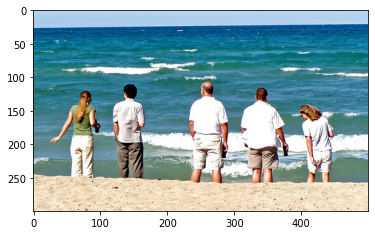

Image with Caption: three girls playing on the beach at the beach


In [ ]:
# Your result
pic = list(encoding_test.keys())[5]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Image with Caption:",imageSearch(image))